**1번** 데이터 확인 및 전처리

데이터 설명

`InvoiceNo`: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter ‘c’, it indicates a cancellation.

`StockCode`: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

`Description`: Product (item) name. Nominal.

`Quantity`: The quantities of each product (item) per transaction. Numeric.

`InvoiceDate`: Invice Date and time. Numeric, the day and time when each transaction was generated.

`UnitPrice`: Unit price. Numeric, Product price per unit in sterling.

`CustomerID`: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

`Country`: Country name. Nominal, the name of the country where each customer resides.

출처

https://archive.ics.uci.edu/ml/index.phpm

In [1]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem1.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,565857,84879,ASSORTED COLOUR BIRD ORNAMENT,16,9/7/2011 14:13,1.69,14911.0,EIRE
1,560452,22432,WATERING CAN PINK BUNNY,6,7/19/2011 9:51,1.95,12682.0,France
2,578509,22492,MINI PAINT SET VINTAGE,36,11/24/2011 13:17,0.65,12705.0,Germany
3,579345,22728,ALARM CLOCK BAKELIKE PINK,8,11/29/2011 11:46,3.75,12727.0,France
4,564039,21731,RED TOADSTOOL LED NIGHT LIGHT,12,8/22/2011 12:40,1.65,12645.0,Germany


**1.1** F(소비자별 구매빈도), M(소비자별 총 구매액) feature를 새로 생성해서 그 결과값으로 탐색적 분석 실시

In [2]:
df = df[~df['InvoiceNo'].map(lambda x: x[0]=='C')]

In [3]:
target = pd.DataFrame()
target['F'] = df['CustomerID'].value_counts()
target.reset_index(inplace=True)
target.columns=['CustomerID', 'F']
target.head()

,CustomerID,F
0,14911.0,5677
1,14646.0,2080
2,14156.0,1400
3,12415.0,716
4,12681.0,638


In [4]:
df['Price'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price
0,565857,84879,ASSORTED COLOUR BIRD ORNAMENT,16,9/7/2011 14:13,1.69,14911.0,EIRE,27.04
1,560452,22432,WATERING CAN PINK BUNNY,6,7/19/2011 9:51,1.95,12682.0,France,11.70
2,578509,22492,MINI PAINT SET VINTAGE,36,11/24/2011 13:17,0.65,12705.0,Germany,23.40
3,579345,22728,ALARM CLOCK BAKELIKE PINK,8,11/29/2011 11:46,3.75,12727.0,France,30.00
4,564039,21731,RED TOADSTOOL LED NIGHT LIGHT,12,8/22/2011 12:40,1.65,12645.0,Germany,19.80


In [5]:
p = df.groupby(by='CustomerID').sum().reset_index().loc[:, ['CustomerID','Price']]
res = pd.merge(target, p, on='CustomerID')
res.columns = ['CustomerID', 'F', 'M']
res.head()

,CustomerID,F,M
0,14911.0,5677,143825.06
1,14646.0,2080,280206.02
2,14156.0,1400,117379.63
3,12415.0,716,124914.53
4,12681.0,638,13787.54


C:\Users\kang\AppData\Local\Temp\ipykernel_4952\2479835752.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df_corr, dtype=np.bool)


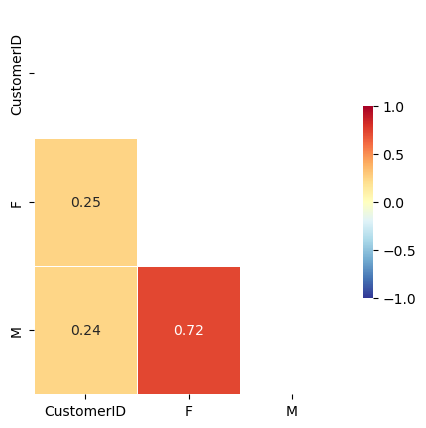

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_corr = res.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(5,5) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(df_corr, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

**1.2** F, M feature 기반으로 군집분석 실시, 필요시 이상값 보정

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

# 클러스터별 콜린스키 하라바츠 결과 비교
for k in range(2, 10):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(res)
    labels = kmeans_model.labels_
    print(calinski_harabasz_score(res, labels))

1753.2511740658517
5761.751620773896
9408.958187713564
11486.620107194549
14905.99594544883
18536.66193660358
19997.208474616593
23026.52739309416


In [8]:
import matplotlib.pyplot as plt
def elbow(X):
    sse=[]
    for i in range(1, 11):
        km=KMeans(n_clusters=i, random_state=1)
        km.fit(X)
        sse.append(km.inertia_)
    
    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel('The Number of Clusters')
    plt.ylabel('SSE')
    plt.show()
    print(sse)

d:\Users\kang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


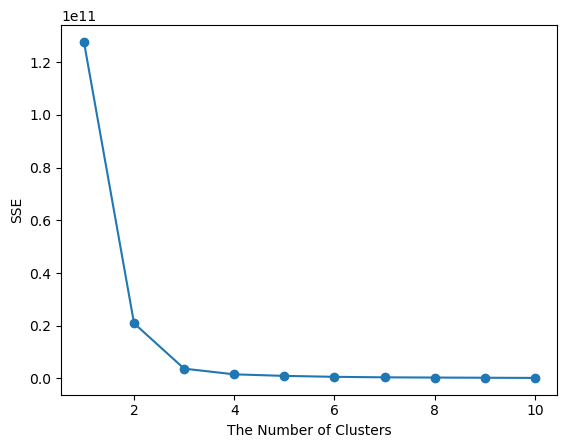

[127704001465.57983, 20895622168.08943, 3680818892.560611, 1524336870.197152, 938118400.9149308, 578308257.2223797, 386919481.13346684, 306706298.0027596, 232505871.31799316, 164072944.41027397]


In [9]:
elbow(res)

d:\Users\kang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


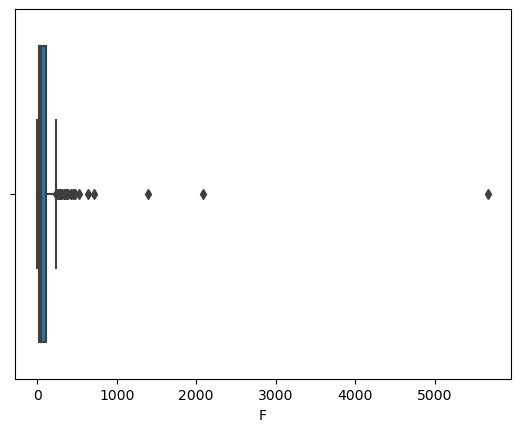

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(res['F'])
plt.show()

d:\Users\kang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


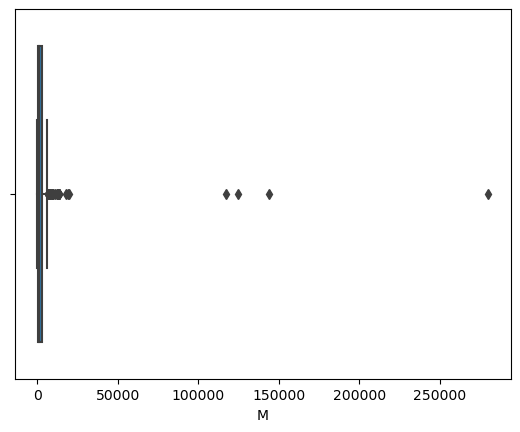

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(res['M'])
plt.show()

In [12]:
import numpy as np

Q1 = res['F'].quantile(0.25)
Q3 = res['F'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

res['F'] = np.where(res['F'] < 0, 0, res['F'])
res['F'] = np.where(res['F'] > upper_bound, upper_bound, res['F'])

In [13]:
Q1 = res['M'].quantile(0.25)
Q3 = res['M'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
res['M'] = np.where(res['M'] < lower_bound, lower_bound, res['M'])
res['M'] = np.where(res['M'] > upper_bound, upper_bound, res['M'])

d:\Users\kang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


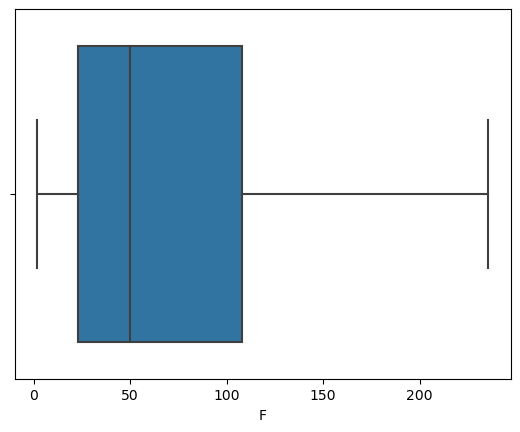

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(res['F'])
plt.show()

d:\Users\kang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


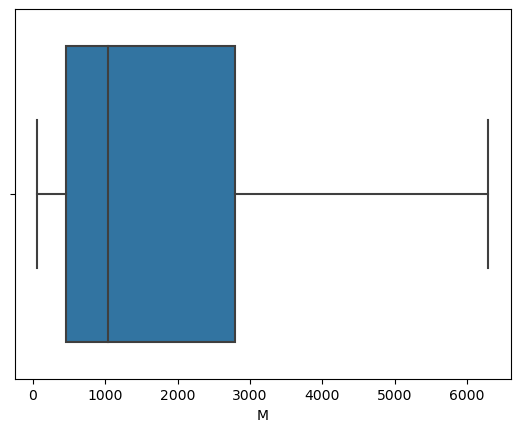

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(res['M'])
plt.show()

In [16]:
from sklearn.cluster import KMeans
import numpy as np


# K-means 알고리즘으로 군집 생성
kmeans = KMeans(n_clusters=3)
kmeans.fit(res)

# 군집 결과 출력
print(kmeans.labels_)
res['class'] = kmeans.labels_

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 1 2 0 1 2 1 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 1
 2 2 2 0 2 2 2 2 0 2 2 1 1 2 0 2 2 2 2 2 2 0 2 2 0 2 0 2 2 2 0 2 0 0 2 2 2
 2 2 0 0 2 2 2 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 2 0 0 0
 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
res

,CustomerID,F,M,class
0,14911.0,235.5,6294.94,1
1,14646.0,235.5,6294.94,1
2,14156.0,235.5,6294.94,1
3,12415.0,235.5,6294.94,1
4,12681.0,235.5,6294.94,1
...,...,...,...,...
340,14566.0,4.0,1432.00,0
341,12789.0,4.0,91.85,0
342,12603.0,3.0,739.20,0
343,12665.0,3.0,63.00,0


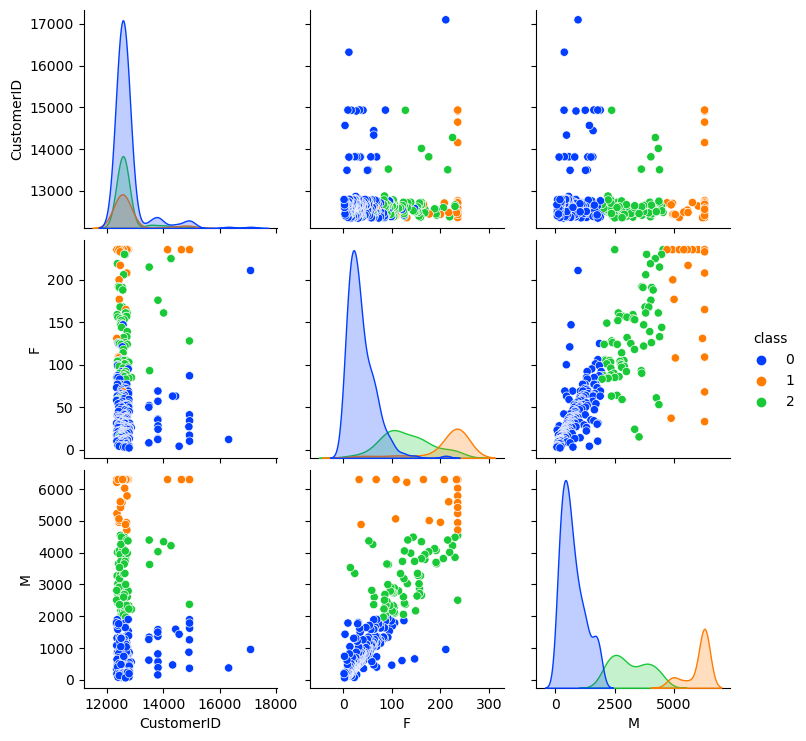

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(res,
             diag_kind='kde',
             hue="class",
#            corner = True,  #직각삼각형 모양으로 산점도 행렬 만드려면 주석해제
             palette='bright')
plt.show()

* 구매 빈도가 높을수록 총 구매액이 높은 패턴을 확인할 수 있다.

In [19]:
res.drop(columns=['class'], inplace=True)

```python
from sklearn.cluster import DBSCAN
import numpy as np

# DBSCAN 알고리즘으로 군집 생성
dbscan = DBSCAN(eps=259.8, min_samples=30)
dbscan.fit(res)

# 군집 결과 출력
print(set(dbscan.labels_))

res['class'] = dbscan.labels_

res['class'].value_counts()
```

```python
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(res,
             diag_kind='kde',
             hue="class",
#            corner = True,  #직각삼각형 모양으로 산점도 행렬 만드려면 주석해제
             palette='bright')
plt.show()
```

**1.3** 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술

군집 분석은 비지도 학습 기법 중 하나로, 비슷한 특성을 가지는 데이터들을 그룹으로 묶는 기법입니다. 군집 분석 결과의 적합성을 평가하기 위해서는 군집 내 응집도(cohesion)와 군집 간 분리도(separation)의 개념을 사용할 수 있습니다.

군집 내 응집도는 같은 그룹에 속한 데이터들이 얼마나 밀접하게 모여있는지를 나타내는 척도입니다. 응집도가 높을수록 군집 내의 데이터들이 서로 유사한 특성을 가지고 있으며, 군집이 잘 형성되었다고 할 수 있습니다. 일반적으로 군집 내 응집도는 군집 내의 데이터들 간 거리의 평균, 분산, 최대값 등으로 계산됩니다. 예를 들어, k-means 알고리즘에서는 군집 내 SSE(Sum of Squared Errors)를 응집도로 사용합니다.

반면, 군집 간 분리도는 서로 다른 그룹 간의 거리가 얼마나 멀리 떨어져 있는지를 나타내는 척도입니다. 분리도가 높을수록 서로 다른 군집 간에는 차이가 크게 나는 특성을 가지고 있으며, 군집이 잘 분리되었다고 할 수 있습니다. 군집 간 분리도는 일반적으로 군집 간 거리의 평균, 분산, 최소값 등으로 계산됩니다. 예를 들어, 분산분석(ANOVA)에서는 군집 간 제곱합(Sum of Squares Between)과 군집 내 제곱합(Sum of Squares Within)을 사용하여 F값을 계산합니다.

따라서, 적합한 군집 분석 결과는 군집 내 응집도가 높고, 군집 간 분리도가 큰 경우입니다. 이는 같은 군집에 속한 데이터끼리는 서로 비슷한 특성을 가지고 있으며, 다른 군집들과는 구분되는 특성을 가지고 있다는 것을 의미합니다.

**1.4** 적합된 군집 별 특성에 대한 의견과 비즈니스적 판단 제시

**2** 시계열분석

In [20]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem2.csv',index_col = 0)
df.head()

,counts
0,544.3
1,603.1
2,NaN
3,533.4
4,619.5


**2.1** EDA와 시각화를 진행하라

In [21]:
df.info()
# 5개의 결측치 존재

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   counts  295 non-null    float64
dtypes: float64(1)
memory usage: 4.7 KB


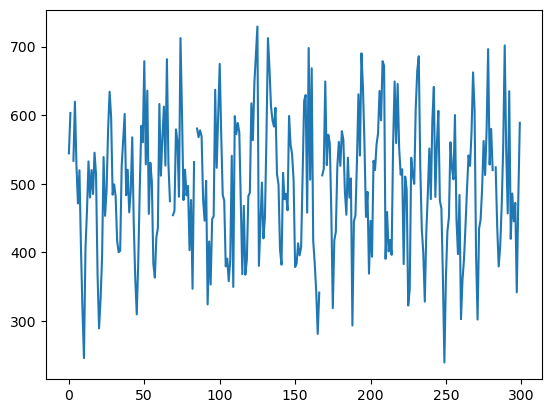

In [22]:
plt.plot(df['counts'])
plt.show()

**2.2** 결측치 처리와 해당 결측치 처리 방식에 대한 논리적 근거를 제시하라

* 결측치 처리 방법 : 결측치 제거, 결측치 대체 등 존재
```python
df = df.dropna()  # 결측치가 있는 모든 행을 삭제합니다.
df = df.dropna(axis=1)  # 결측치가 있는 모든 열을 삭제합니다.
```
```python
df = df.fillna(0)  # 결측치를 0으로 대체합니다.
df = df.fillna(method='ffill')  # 결측치를 앞의 값으로 대체합니다.
df = df.fillna(method='bfill')  # 결측치를 뒤의 값으로 대체합니다.
```

시계열 데이터의 결측치 처리에는 여러가지 방법이 있지만, 그 방법을 선택할 때에는 논리적인 근거가 필요합니다. 결측치를 처리하는 방법은 크게 두 가지로 나눌 수 있습니다.

첫째, 결측치를 삭제하는 방법이 있습니다. 이 방법은 결측치가 있는 데이터를 삭제하고 분석을 수행합니다. 이 방법은 간단하고 직관적입니다. 하지만, 결측치가 있는 데이터를 삭제하는 경우 해당 데이터의 중요한 정보가 유실되어 분석결과가 왜곡될 수 있습니다. 특히 시계열 데이터의 경우에는 결측치가 있으면 그 이후의 데이터에 대한 예측에 영향을 미치기 때문에 삭제하기 어려운 경우가 많습니다.

둘째, 결측치를 대체하는 방법이 있습니다. 이 방법은 결측치를 다른 값으로 대체하고 분석을 수행합니다. 이 방법은 삭제하는 방법보다 데이터의 손실을 최소화할 수 있습니다. 다양한 결측치 대체 방법이 있지만, 대표적으로는 다음과 같습니다.

>평균 대체 (Mean Imputation) : 결측치를 해당 변수의 전체 데이터의 평균으로 대체합니다. 이 방법은 쉽고 빠르지만, 변수의 분포가 한쪽으로 치우친 경우에는 왜곡된 결과를 가져올 수 있습니다.  
>  
>보간법 (Interpolation) : 결측치의 앞뒤 값들을 활용하여 결측치를 추정하는 방법입니다. 이 방법은 해당 데이터가 시계열 데이터인 경우에 효과적입니다. 그러나 데이터의 패턴이 불규칙하고, 이상치가 많은 경우에는 정확한 대체가 어려울 수 있습니다.  
>  
>회귀분석 (Regression Analysis) : 다른 변수를 활용하여 결측치를 추정하는 방법입니다. 이 방법은 변수 간의 상관관계를 고려하여 결측치를 추정하기 때문에 대체 결과의 정확도가 높을 수 있습니다. 하지만, 변수 간의 상관관계가 없는 경우에는 정확한 대체가 어려울 수 있습니다.  

결측치 처리 방법을 선택할 때에는 데이터의 특성과 분석 목적을 고려하여 논리적으로 선택해야 합니다. 데이터의 손실을 최소화하면서 분석 결과의 정확성을 보장하는 것이 중요합니다.

* 해당 경우엔 시계열 데이터의 결측치를 처리해야하기 때문에 보간법을 활용하여 앞 or 뒤의 값으로 대체하고자 합니다.

In [23]:
df = df.fillna(method='ffill') # 결측치를 앞의 값으로 대체합니다.

**2.3** 계절성을 반영한 시계열 모델을 제시하고 정확도 측면에서 모델 성능 평가 할 것

In [24]:
df.index = pd.date_range(start='2021-01-01', periods=len(df))

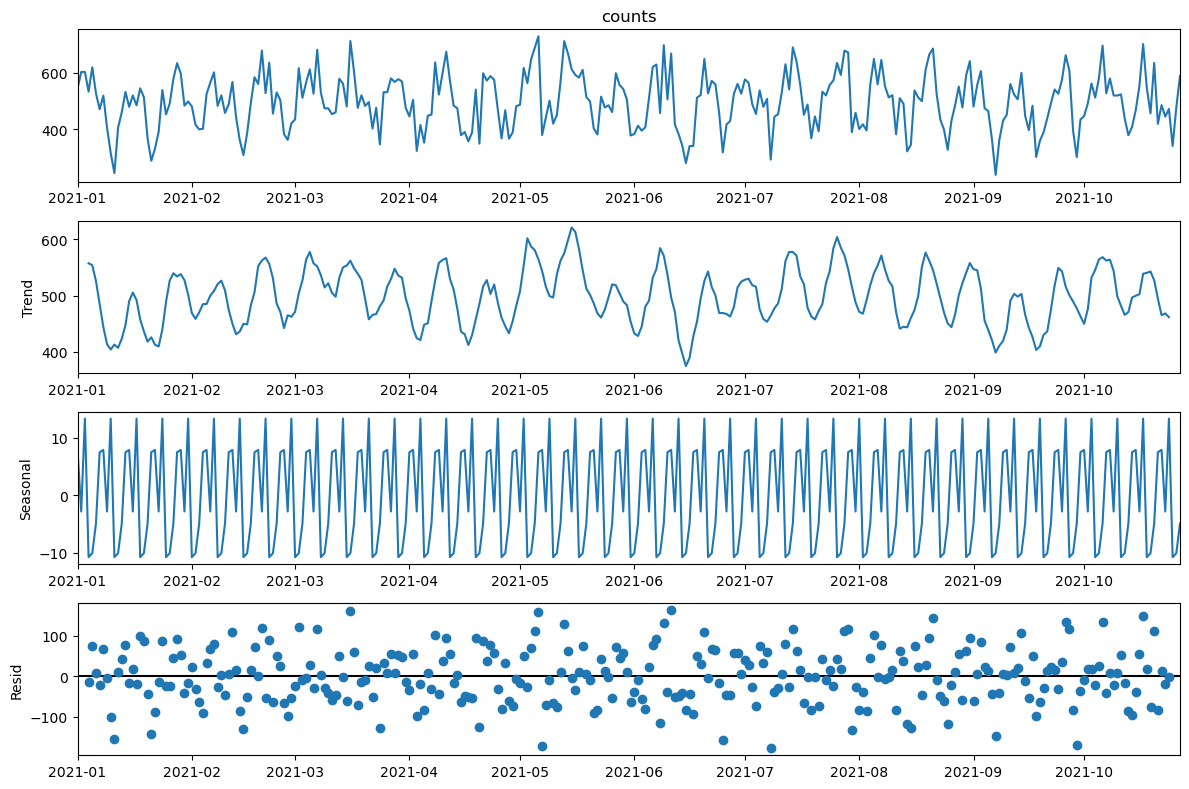

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

ts = df['counts']
result = seasonal_decompose(ts, model='additive')


plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()


In [26]:
## 귀무가설 : 데이터가 정상성(stationary)을 갖지 않는다. (변동이 있다.)
## 대립가설 : 데이터가 정상성(stationary)을 갖는다 

from statsmodels.tsa.stattools import adfuller

adf = adfuller(ts, regression='ct')

print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic: -3.5594201592844934
p-value : 0.033449812993074146


In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_data = ts.diff(1).dropna()

d:\Users\kang\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


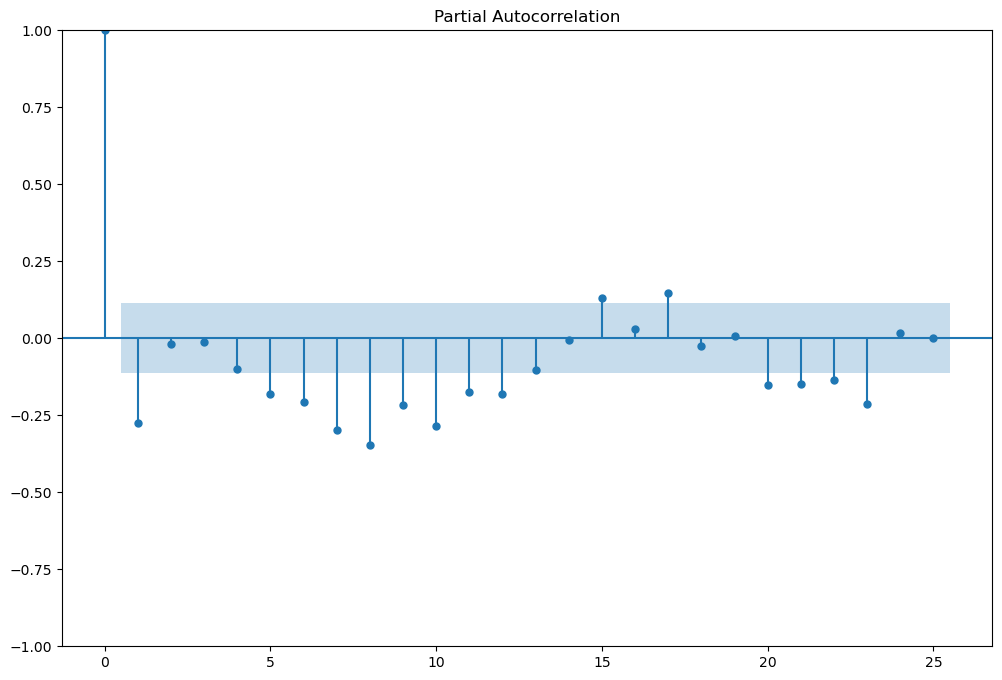

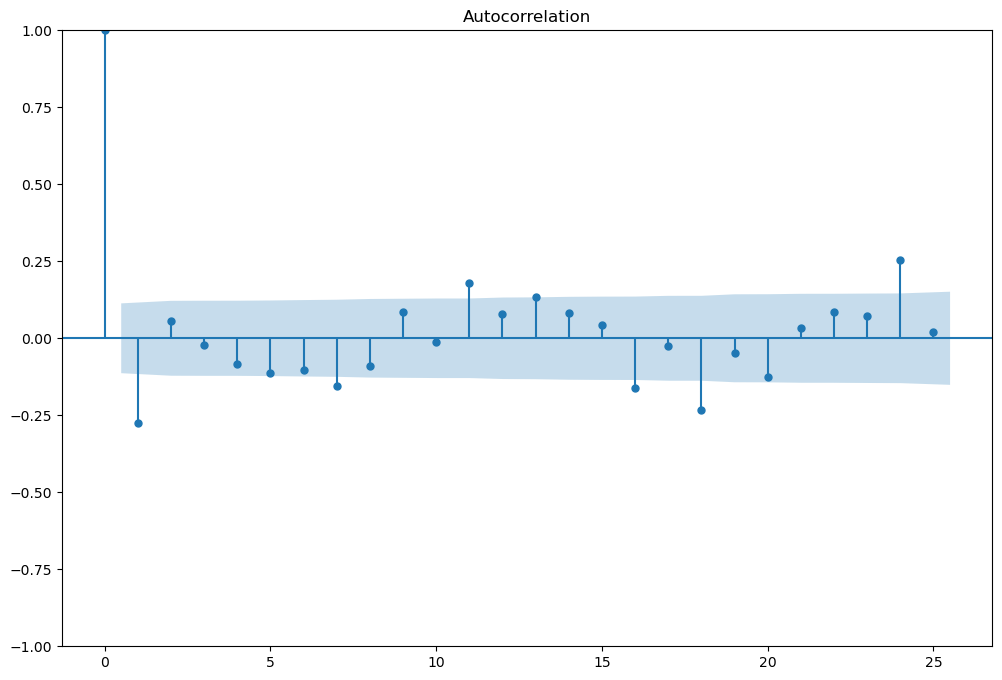

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np 
import matplotlib.pyplot as plt

plot_pacf(diff_data) #AR(p)의 값 확인 가능 ==2 

plot_acf(diff_data) #MA(q)의 값 확인 가능 == 2

plt.show()

In [29]:
ts_train, ts_test = ts[:270], ts[270:]

In [30]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(ts_train.values, 
                  order=(0,1,1), seasonal_order=(1,1,1,12),
                  trend='ct',
                  enforce_stationarity=False, 
                  enforce_invertibility=False)

results = model.fit()
results.summary()

d:\Users\kang\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  270
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1395.641
Date:                            Sat, 18 Feb 2023   AIC                           2803.283
Time:                                    23:38:28   BIC                           2824.241
Sample:                                         0   HQIC                          2811.725
                                            - 270                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.2848      1.740     -2.462      0.014      -7.696      -0.874
drift          0.0131      0.010      1.323      0.186      -0.006       0.032
ma.L1         -0.7340      0.054    -13.571      0.000      -0.840      -0.628
ar.S.L12      -0.2794      0.085     -3.270      0.001      -0.447      -0.112
ma.S.L12      -0.6594      0.083     -7.903      0.000      -0.823      -0.496
sigma2      5746.5949    703.941      8.163      0.000    4366.895    7126.295
===================================================================================
Ljung-Box (L1) (Q):                   1.85   Jarque-Bera (JB):                 1.93
Prob(Q):                              0.17   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                             0.01
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**2.4** 분석 결과 활용 가능 여부에 대한 분석 전문가로서의 제안

### 데이터 확인

1. 시간 경과에 따른 표준화 잔차
2. 히스토그램과 표준화 된 잔차의 추정 된 밀도, 참조를 위해 그려진 Normal (0,1) 밀도.
3. 일반 기준선이있는 일반 QQ 플롯.
4. 상관도

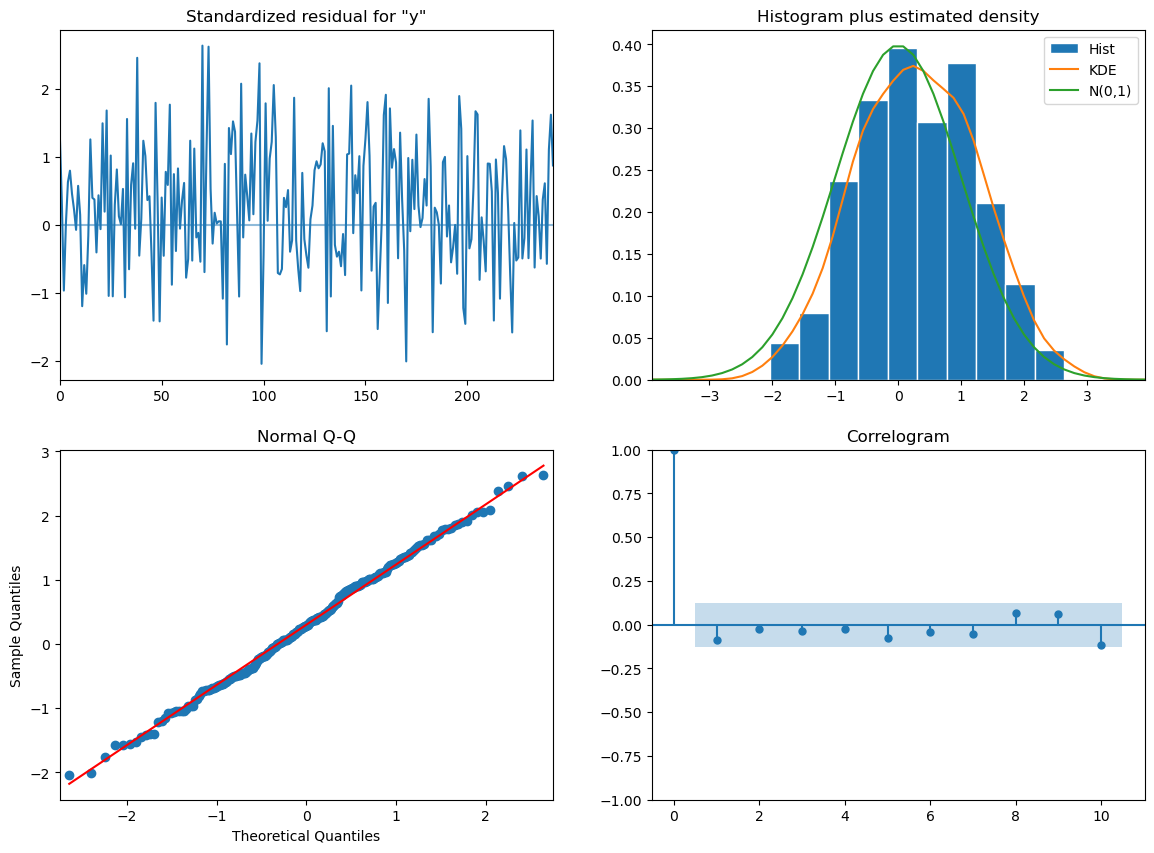

In [31]:
results.plot_diagnostics(figsize=(14, 10))
plt.show()

In [32]:
forecast_values = results.get_forecast(steps=len(ts_test))

forecast_values.summary_frame()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,434.614164,75.806299,286.036547,583.191780
1,439.468224,78.442561,285.723629,593.212820
2,368.188577,80.993061,209.445095,526.932059
3,329.335973,83.465659,165.746287,492.925660
4,394.123316,85.867088,225.826917,562.419715
5,477.151746,88.203158,304.276733,650.026760
6,483.947840,90.478934,306.612387,661.283293
7,531.802778,92.698856,350.116358,713.489198
8,560.903494,94.866846,374.967893,746.839094
9,514.795594,96.986385,324.705773,704.885416


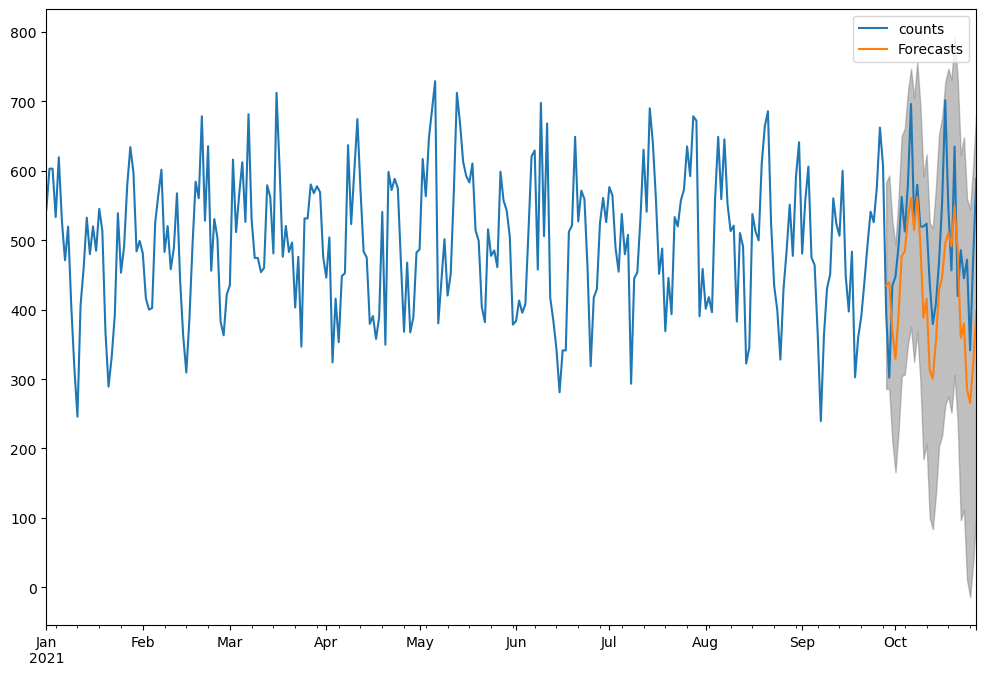

In [33]:
#pred_ci = forecast_values.conf_int()
ax = ts.plot() ## 실제 값 

pred_ci = pd.DataFrame(forecast_values.conf_int())
pred_ci.index = list(ts_test.index)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=0.5)

predicted = pd.DataFrame(forecast_values.predicted_mean)
predicted.index = list(ts_test.index)
predicted.columns = ['Forecasts']
predicted.plot(ax=ax, label="Forecasts")


plt.legend()
plt.show()

**3.1** 서울에서 영동까지 100km/h로 가고 영동에서 서울까지 80km/로 돌아왔을 때, 평균 속도는

<img src='./조화평균.png' width=800>

In [34]:
go = 100
come = 80

mean = 2 / (1/go + 1/come)
print(round(mean,2))

88.89


**3.2** 연매출이 3000, 4000, 5000이었다면 연평균 몇배가 증가한 것인가?

<img src='./기하평균.png' width=800>

In [35]:
first = 1.33
second = 1.25
# import numpy as np 
# r = np.sqrt((first-1) * (second-1))
r = ((first-1) * (second-1))**(1/2)
print('연평균 증가율 : ', round(r*100, 2), '%')


연평균 증가율 :  28.72 %


**3.3** 남성, 여성의 등산, 수영에 대한 취미 선호도 빈도표(2x2)를 보고, 남성 중에서 등산을 좋아할 확률을 구하시오  
등산|수영  
남자|20|10  
여자|15|30  

<img src='./조건부확률.png' width=800>

In [36]:
n_man = 30
n_man_and_climb = 20
p_b_a = n_man_and_climb / n_man
print(round(p_b_a* 100, 2), '%')

66.67 %


**3.4** 표본 10개의 분산이 90일 때 신뢰도 95%로 모분산의 신뢰구간을 추정

정규분포를 따르는 모집단에서 추출된 크기가 10인 표본의 분산이 90이라는 것은, 모집단의 분산인 $\sigma^2$가 90일 수도 있고, 아닐 수도 있다는 것을 의미합니다.

신뢰도 95%로 모분산의 신뢰구간을 추정하기 위해서는, 자유도가 9인 카이제곱 분포에서 상위 2.5%에 해당하는 값을 찾아야 합니다. 이 값은 19.02입니다.

따라서, 모분산 $\sigma^2$의 95% 신뢰구간은 다음과 같습니다.

$$(\frac{(n-1)S^2}{\chi^2_{0.025, n-1}}, \frac{(n-1)S^2}{\chi^2_{0.975, n-1}})$$

여기서, $n$은 표본의 크기, $S^2$은 표본 분산, $\chi^2_{0.025, n-1}$과 $\chi^2_{0.975, n-1}$은 각각 자유도가 $n-1$인 카이제곱 분포에서 상위 2.5%와 하위 2.5%에 해당하는 값입니다.

따라서, 신뢰도 95%로 모분산의 신뢰구간을 추정하면 다음과 같습니다.

$$(\frac{(10-1)\times90}{19.02}, \frac{(10-1)\times90}{2.70}) \approx (42.59, 299.96)$$

즉, 모분산 $\sigma^2$은 95%의 확률로 42.59 이상 299.96 이하일 것으로 추정됩니다.

In [1]:
from scipy.stats import chi2
import math

def confidence_interval_for_variance(sample_variance, sample_size, confidence_level):
    dof = sample_size - 1
    alpha = 1 - confidence_level
    lower_percentile = alpha / 2
    upper_percentile = 1 - (alpha / 2)
    lower_chi2 = chi2.ppf(lower_percentile, dof)
    upper_chi2 = chi2.ppf(upper_percentile, dof)
    lower = (dof * sample_variance) / upper_chi2
    upper = (dof * sample_variance) / lower_chi2
    return (lower, upper)


In [2]:
sample_variance = 90
sample_size = 10
confidence_level = 0.95

result = confidence_interval_for_variance(sample_variance, sample_size, confidence_level)
print("95% confidence interval for population variance: ({:.2f}, {:.2f})".format(result[0], result[1]))


95% confidence interval for population variance: (42.58, 299.96)


In [23]:
chi2.ppf(0.975, df=9)

19.02276779864163

In [22]:
chi2.ppf(0.025, df=9)

2.7003894999803584

In [38]:
df = 9
v = 90
alpha = 0.05
df* v / chi2.interval(alpha=1-alpha, df=9)[1], df* v / chi2.interval(alpha=1-alpha, df=9)[0]

(42.58055444790953, 299.95672846672363)

**4** 10명의 환자 대상 수면영양제 복용 전과 후의 수면시간 측정    
영양제의 효과가 있는지를 판단하고자 함.     
(표본이 정규성을 만족한다는 가정 하에 단측검정 수행, 유의수준 = 0.05)

**4.1** 귀무가설과 연구가설을 제시하시오

가설 설정:

귀무가설(H0): 혈압약 투약 이전과 이후의 차이가 없다 (평균 차이 = 0)  
연구가설(H1): 혈압약 투약 이전과 이후의 차이가 있다 (평균 차이 ≠ 0)  


**4.2** 검정 후 귀무가설 기각 여부 제시

In [39]:
import pandas as pd 
data = {'before':[7,3,4,5,2,1,6,6,5,4],
       'after':[8,4,5,6,2,3,6,8,6,5]}
data = pd.DataFrame(data)
data

,before,after
0,7,8
1,3,4
2,4,5
3,5,6
4,2,2
5,1,3
6,6,6
7,6,8
8,5,6
9,4,5


In [40]:
import scipy.stats as stats
stats.ttest_rel(data['after'],data['before'],alternative='greater')

Ttest_relResult(statistic=4.743416490252569, pvalue=0.0005269356285082765)

[결과해석]   
* 첫번째 값 (검정통게치) : 4.7434   
* 두번째 값 (p-value) : 0.001   
==> 유의수준보다 작으므로 '수면영양제를 복용하기 전과 후의 평균 수면시간의 차이는 통계적으로 유의하며, 영양제를 복용한 후 수면시간이 늘었다'는 결론

**5** 공장 X,Y,Z의 평균 출하 소요시간을 여러 일자에 거쳐 측정한 데이터이다. 각 공장의 중위수의 차이가 존재하는지 확인하려 한다

In [41]:
import pandas as pd
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem5.csv',encoding='cp949')
df.head()

,출하 소요시간,공장명,공장별 출하 소요시간 순위
0,71,Z,11
1,75,X,14
2,71,X,12
3,53,Z,1
4,50,X,1


**5.1** 귀무가설과 연구가설을 제시하시오

* H0 : 각 공장의 평균 출하 소요시간에 대한 중위수는 동일하다.
* H1 : 각 공장의 평균 출하 소요시간에 대한 중위수는 동일하지 않다.

**5.2** 검정 후 귀무가설 기각 여부 제시

검정 방법:

이 문제에서는 Kruskal-Wallis 검정을 사용할 수 있습니다. Kruskal-Wallis 검정은 세 개 이상의 집단 간에 차이가 있는지 검정하는 비모수적인 방법 중 하나입니다. 중위수는 이와 같은 비모수적인 검정에서 사용할 수 있는 대표적인 대푯값입니다.

In [42]:
from scipy.stats import kruskal

# Kruskal-Wallis 검정 수행
X = df[df['공장명'].map(lambda x : x=='X')]['출하 소요시간']
Y = df[df['공장명'].map(lambda x : x=='Y')]['출하 소요시간']
Z = df[df['공장명'].map(lambda x : x=='Z')]['출하 소요시간']
statistic, p_value = kruskal(X, Y, Z)

# 결과 출력
if p_value < 0.05:
    print("공장 X, Y, Z의 중위수는 차이가 있다.")
else:
    print("공장 X, Y, Z의 중위수는 차이가 없다.")
print(f"검정통계량: {statistic:.2f}, p-value: {p_value:.2f}")
print(f'실제 각 중위수는 ({X.median()}, {Y.median()}, {Z.median()})이다.')

공장 X, Y, Z의 중위수는 차이가 없다.
검정통계량: 0.72, p-value: 0.70
실제 각 중위수는 (64.0, 67.0, 66.5)이다.


**6.** 1개년 50억원, 2개년 60억원, 3개년 70억원의 예산을 가지고 NPV(순현재가치)가 가장 높아지는 안을 제시하시오

1개년 2개년 3개년  
1안 10 20 15  
2안 15 14 19  
3안 12 11 30  
4안 13 25 20  
5안 16 30 24  

NPV(Net Present Value, 순현재가치)는 현재 가치로의 투자 비용과 예상되는 현금 흐름의 현재 가치의 차이를 나타내는 투자 분석 지표입니다. 다음과 같은 공식으로 계산됩니다.  

NPV = -Initial Investment + (CF1/(1+r)^1) + (CF2/(1+r)^2) + ... + (CFn/(1+r)^n)  

여기서,  

Initial Investment: 투자 초기 비용  
CF1, CF2, ..., CFn: 예상 현금 흐름 (cash flow)으로, 각 기간마다의 현금 흐름을 나타냅니다.  
r: 할인율 (discount rate)로, 투자의 위험성, 시장금리 등을 고려하여 산정됩니다.  
할인율은 일반적으로 투자의 위험성이 높을수록 높게 책정됩니다. 이 공식에서 계산된 NPV가 0보다 크면, 해당 투자는 이윤이 발생할 가능성이 높습니다. 반대로, NPV가 0보다 작으면, 해당 투자는 이익보다 손실이 발생할 가능성이 높습니다.  

NPV(순현재가치)는 투자액의 현재 가치에서 예상 수익을 고려하여 계산된 값으로, 여러 가지 요인들을 고려해야 합니다. 주어진 예산이 50억원, 60억원, 70억원으로 차례로 증가하는데, 이를 고려하여 예산 범위 내에서 가장 높은 NPV를 가지는 안을 선택해야 합니다.  

~~우선 각 안의 NPV를 계산해보면 다음과 같습니다.  ~~

~~1안:  ~~
~~NPV = -50 + (10/1) + (20/(1+R)^2) + (15/(1+R)^3)  ~~

~~2안:  ~~
~~NPV = -60 + (15/1) + (14/(1+R)^2) + (19/(1+R)^3)  ~~

~~3안:  ~~
~~NPV = -70 + (12/1) + (11/(1+R)^2) + (30/(1+R)^3)  ~~

~~4안:  ~~
~~NPV = -50 + (13/1) + (25/(1+R)^2) + (20/(1+R)^3)  ~~

~~5안:  ~~
~~NPV = -60 + (16/1) + (30/(1+R)^2) + (24/(1+R)^3)  ~~

~~여기서 R은 할인율을 나타내며, 이 문제에서는 주어지지 않았으므로 10%를 사용하겠습니다. 그러면 NPV를 계산해보면 다음과 같습니다.  ~~

~~1안: 1.47억원  ~~
~~2안: 3.34억원  ~~
~~3안: 7.20억원  ~~
~~4안: 6.73억원  ~~
~~5안: 8.60억원  ~~

~~따라서, 예산 범위 내에서 가장 높은 NPV를 가지는 안은 5안입니다. 따라서, 3개년 동안 16억원, 30억원, 24억원의 예산을 투자하는 것이 가장 이익이 됩니다.~~